# Compare our identified macropahge clusters with Grant, et al, Nature, 2021

In [1]:
suppressPackageStartupMessages({
    library(harmony)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(patchwork)
    library(Matrix)
    library(uwot)
    library(plyr)
    library(dplyr)
    library(singlecellmethods)
    library(class) # for knn
    library(Seurat)
    library(RANN) # for nn
    library(reshape2) # for nn
    library(GGally) # for ggpairs
    library(symphony)
    
    # for figures
    library(scico)
    library(ggrastr)
    library(ggpubr)
    library(ggplot2)
    library(ggthemes)
    library(RColorBrewer)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [2]:
suppressMessages({
    library(data.table)
    library(gdata)
    library(magrittr)
    library(gridExtra)
    library(cowplot)
    library(reticulate)
    library(ggbeeswarm)
    library(ggrepel)
    library(MASS)
    library(grid)
    require(gdata)
    library(Rcpp)
    library(scales)
    library(irlba)
    library(parallel)
    library(pbapply)
    library(pheatmap)
    library(entropy)
    library(Rtsne)
    library(loe)
    library(igraph)
    library(viridis)
    library(RcppArmadillo)
    library(SeuratDisk)
})

In [3]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

# Tissue macrophage clusters

In [4]:
tis_meta <- readRDS("/data/srlab1/fzhang/results/2020_06_04_weighted_pca_harmony_multi_tissue_macrophage/meta_all_weighted_macropahge_cosine_s_d_ds_new_cluster_2020_12_30.rds")
tis_exprs_norm <- readRDS("/data/srlab1/fzhang/results/2020_06_04_weighted_pca_harmony_multi_tissue_macrophage/exprs_norm_macropahge_new_2020_12_30.rds")
table(tis_meta$res_0.20_annot)


CXCL10+ CCL2+         FCN1+  MRC1+ FABP4+   Macropahges 
        13453          7082         44052          9786 

## Load another severe COVID-19 BALF data from Grant, et al, 2021

In [5]:
grant_meta <- fread("/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_main-metadata.csv.gz")
dim(grant_meta)
table(grant_meta$Cluster)
table(grant_meta$`Sample status`)
table(grant_meta$`Sample type`)
table(grant_meta$`COVID-19`)
grant_meta[1:4,]

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


[1] 77146    15


           AT2, AT1 cells                   B cells            CD4 CM T cells 
                      260                       498                      5544 
    CD4 cytotoxic T cells       CD4 prolif. T cells     CD8 cytotoxic T cells 
                     1867                      1003                      4524 
CD8 cytotoxic TRM T cells       CD8 prolif. T cells            Ciliated cells 
                     3269                      1175                      1467 
        Club, Basal cells                       DC1                       DC2 
                      394                       812                       470 
  Infected AT2, AT1 cells                 Ionocytes                Mast cells 
                       74                        54                        30 
             Migratory DC             Mixed myeloid                     MoAM1 
                      833                      1350                      4283 
                    MoAM2                     MoAM3


 Cryo Fresh 
51689 25457 


  BAL 
77146 


 TRUE 
77146 

V1,Patient,Day after intubation,Sample type,Sample,Sample status,Cluster,COVID-19,No of SARS-CoV-2 genes,IFNA Response,IFNG Response,No of genes,No of UMIs,% of mito genes,% of ribo genes
AAACCTGAGAAACCGC-0,4,1,BAL,1,Fresh,iNKT cells,TRUE,1,0.1639664,0.2012209,636,961,2.7055151,24.037460
AAACCTGAGCGTTTAC-0,4,1,BAL,1,Fresh,CD8 cytotoxic T cells,TRUE,0,0.4143600,0.3156655,577,754,1.1936339,12.864721
AAACCTGCAACTGCGC-0,4,1,BAL,1,Fresh,MoAM2,TRUE,11,0.6529789,0.5881350,1026,1922,2.1852238,8.688866
AAACCTGCATTGAGCT-0,4,1,BAL,1,Fresh,CD4 CM T cells,TRUE,0,0.9536337,0.5531278,690,1132,0.7067138,25.706715


In [ ]:
grant <- fread("/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_X.csv")
class(grant)
dim(grant)

In [14]:
grant_gene <- fread("/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_gene.csv")
grant_exp <- as(as.matrix(t(grant)), "sparseMatrix")   

[1] 21820     2

V1,V2
<int>,<chr>
NA,0
0,A1BG
1,A1BG-AS1
2,A2M


In [26]:
class(grant_exp)
rownames(grant_exp) <- grant_gene$V2[-1]
colnames(grant_exp) <- grant_meta$V1
grant_exp[1:4,1:4]

[1] "dgCMatrix"
attr(,"package")
[1] "Matrix"

4 x 4 sparse Matrix of class "dgCMatrix"
         AAACCTGAGAAACCGC-0 AAACCTGAGCGTTTAC-0 AAACCTGCAACTGCGC-0
A1BG            -0.29330596        -0.29330596        -0.29330596
A1BG-AS1        -0.14330266        -0.14330266        -0.14330266
A2M             -0.21552667        -0.21552667        -0.21552667
A2M-AS1         -0.07011624        -0.07011624        -0.07011624
         AAACCTGCATTGAGCT-0
A1BG            -0.29330596
A1BG-AS1        -0.14330266
A2M             -0.21552667
A2M-AS1         -0.07011624

In [28]:
temp <- fread("/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_obsm.csv")
dim(temp)
temp[1:4,]

[1] 77146     5

V1,X_pca1,X_pca2,X_umap1,X_umap2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AAACCTGAGAAACCGC-0,-1.347058,11.232028,-7.702774,2.026680
AAACCTGAGCGTTTAC-0,-2.238412,9.645941,-6.923362,1.696023
AAACCTGCAACTGCGC-0,-3.003791,-7.215778,5.758034,3.742229
AAACCTGCATTGAGCT-0,-2.094021,7.208645,-11.239088,1.966853


In [32]:
grant_meta <- cbind(grant_meta, temp)
grant_meta <- as.data.frame(grant_meta)
colnames(grant_meta)[1] <- "cell"
grant_meta[1:4,]

,cell,Patient,Day after intubation,Sample type,Sample,Sample status,Cluster,COVID-19,No of SARS-CoV-2 genes,IFNA Response,IFNG Response,No of genes,No of UMIs,% of mito genes,% of ribo genes,V1,X_pca1,X_pca2,X_umap1,X_umap2
,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAACCTGAGAAACCGC-0,4,1,BAL,1,Fresh,iNKT cells,TRUE,1,0.1639664,0.2012209,636,961,2.7055151,24.037460,AAACCTGAGAAACCGC-0,-1.347058,11.232028,-7.702774,2.026680
2,AAACCTGAGCGTTTAC-0,4,1,BAL,1,Fresh,CD8 cytotoxic T cells,TRUE,0,0.4143600,0.3156655,577,754,1.1936339,12.864721,AAACCTGAGCGTTTAC-0,-2.238412,9.645941,-6.923362,1.696023
3,AAACCTGCAACTGCGC-0,4,1,BAL,1,Fresh,MoAM2,TRUE,11,0.6529789,0.5881350,1026,1922,2.1852238,8.688866,AAACCTGCAACTGCGC-0,-3.003791,-7.215778,5.758034,3.742229
4,AAACCTGCATTGAGCT-0,4,1,BAL,1,Fresh,CD4 CM T cells,TRUE,0,0.9536337,0.5531278,690,1132,0.7067138,25.706715,AAACCTGCATTGAGCT-0,-2.094021,7.208645,-11.239088,1.966853


In [33]:
all(grant_meta$cell == colnames(grant_exp))

[1] TRUE

In [34]:
# saveRDS(grant_exp, "/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_norm_exprs.rds")
# saveRDS(grant_meta, "/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_meta.rds")

In [131]:
# Load the saved Grant's data
grant_exp <- readRDS("/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_norm_exprs.rds")
grant_meta <- readRDS("/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/public_data/GSE155249_Grant_Covid_Nature/GSE155249_meta.rds")

In [153]:
library(RColorBrewer)
colors37 = c("#466791","#60bf37","#953ada","#4fbe6c","#ce49d3","#a7b43d","#5a51dc","#d49f36","#552095","#507f2d","#db37aa","#84b67c","#a06fda","#df462a","#5b83db","#c76c2d","#4f49a3","#82702d","#dd6bbb","#334c22","#d83979","#55baad","#dc4555","#62aad3","#8c3025","#417d61","#862977","#bba672","#403367","#da8a6d","#a79cd4","#71482c","#c689d0","#6b2940","#d593a7","#895c8b","#bd5975")

null device 
          1

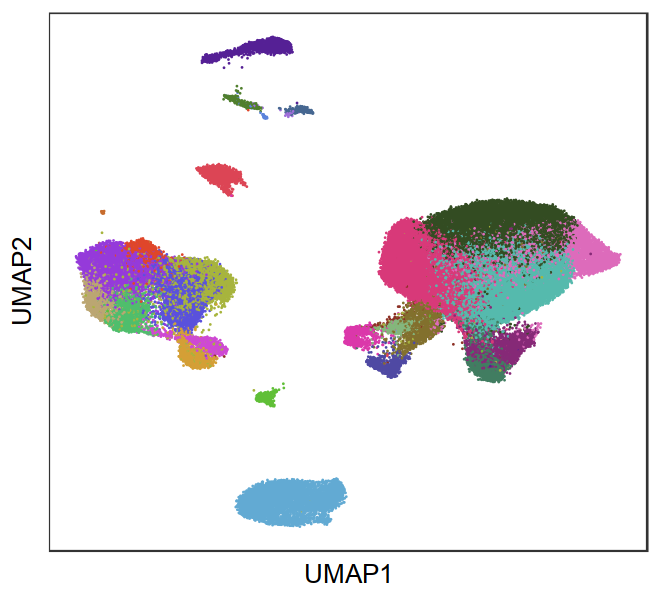

In [158]:
options(repr.plot.height = 5, repr.plot.width = 5.5)
ggplot(grant_meta,
       aes(x = X_umap1, y = X_umap2, fill= Cluster)
      ) +
  geom_point(size = 0.5, stroke = 0.0001, shape = 21) +
  scale_fill_manual(values = colors37, name = "") +
  labs(x = "UMAP1", y = "UMAP2") +
  theme_bw(base_size = 15) +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)
ggsave(file = paste("grant_umap", ".png", sep = ""), width = 5.5, height = 5, dpi = 300)
dev.off()

null device 
          1

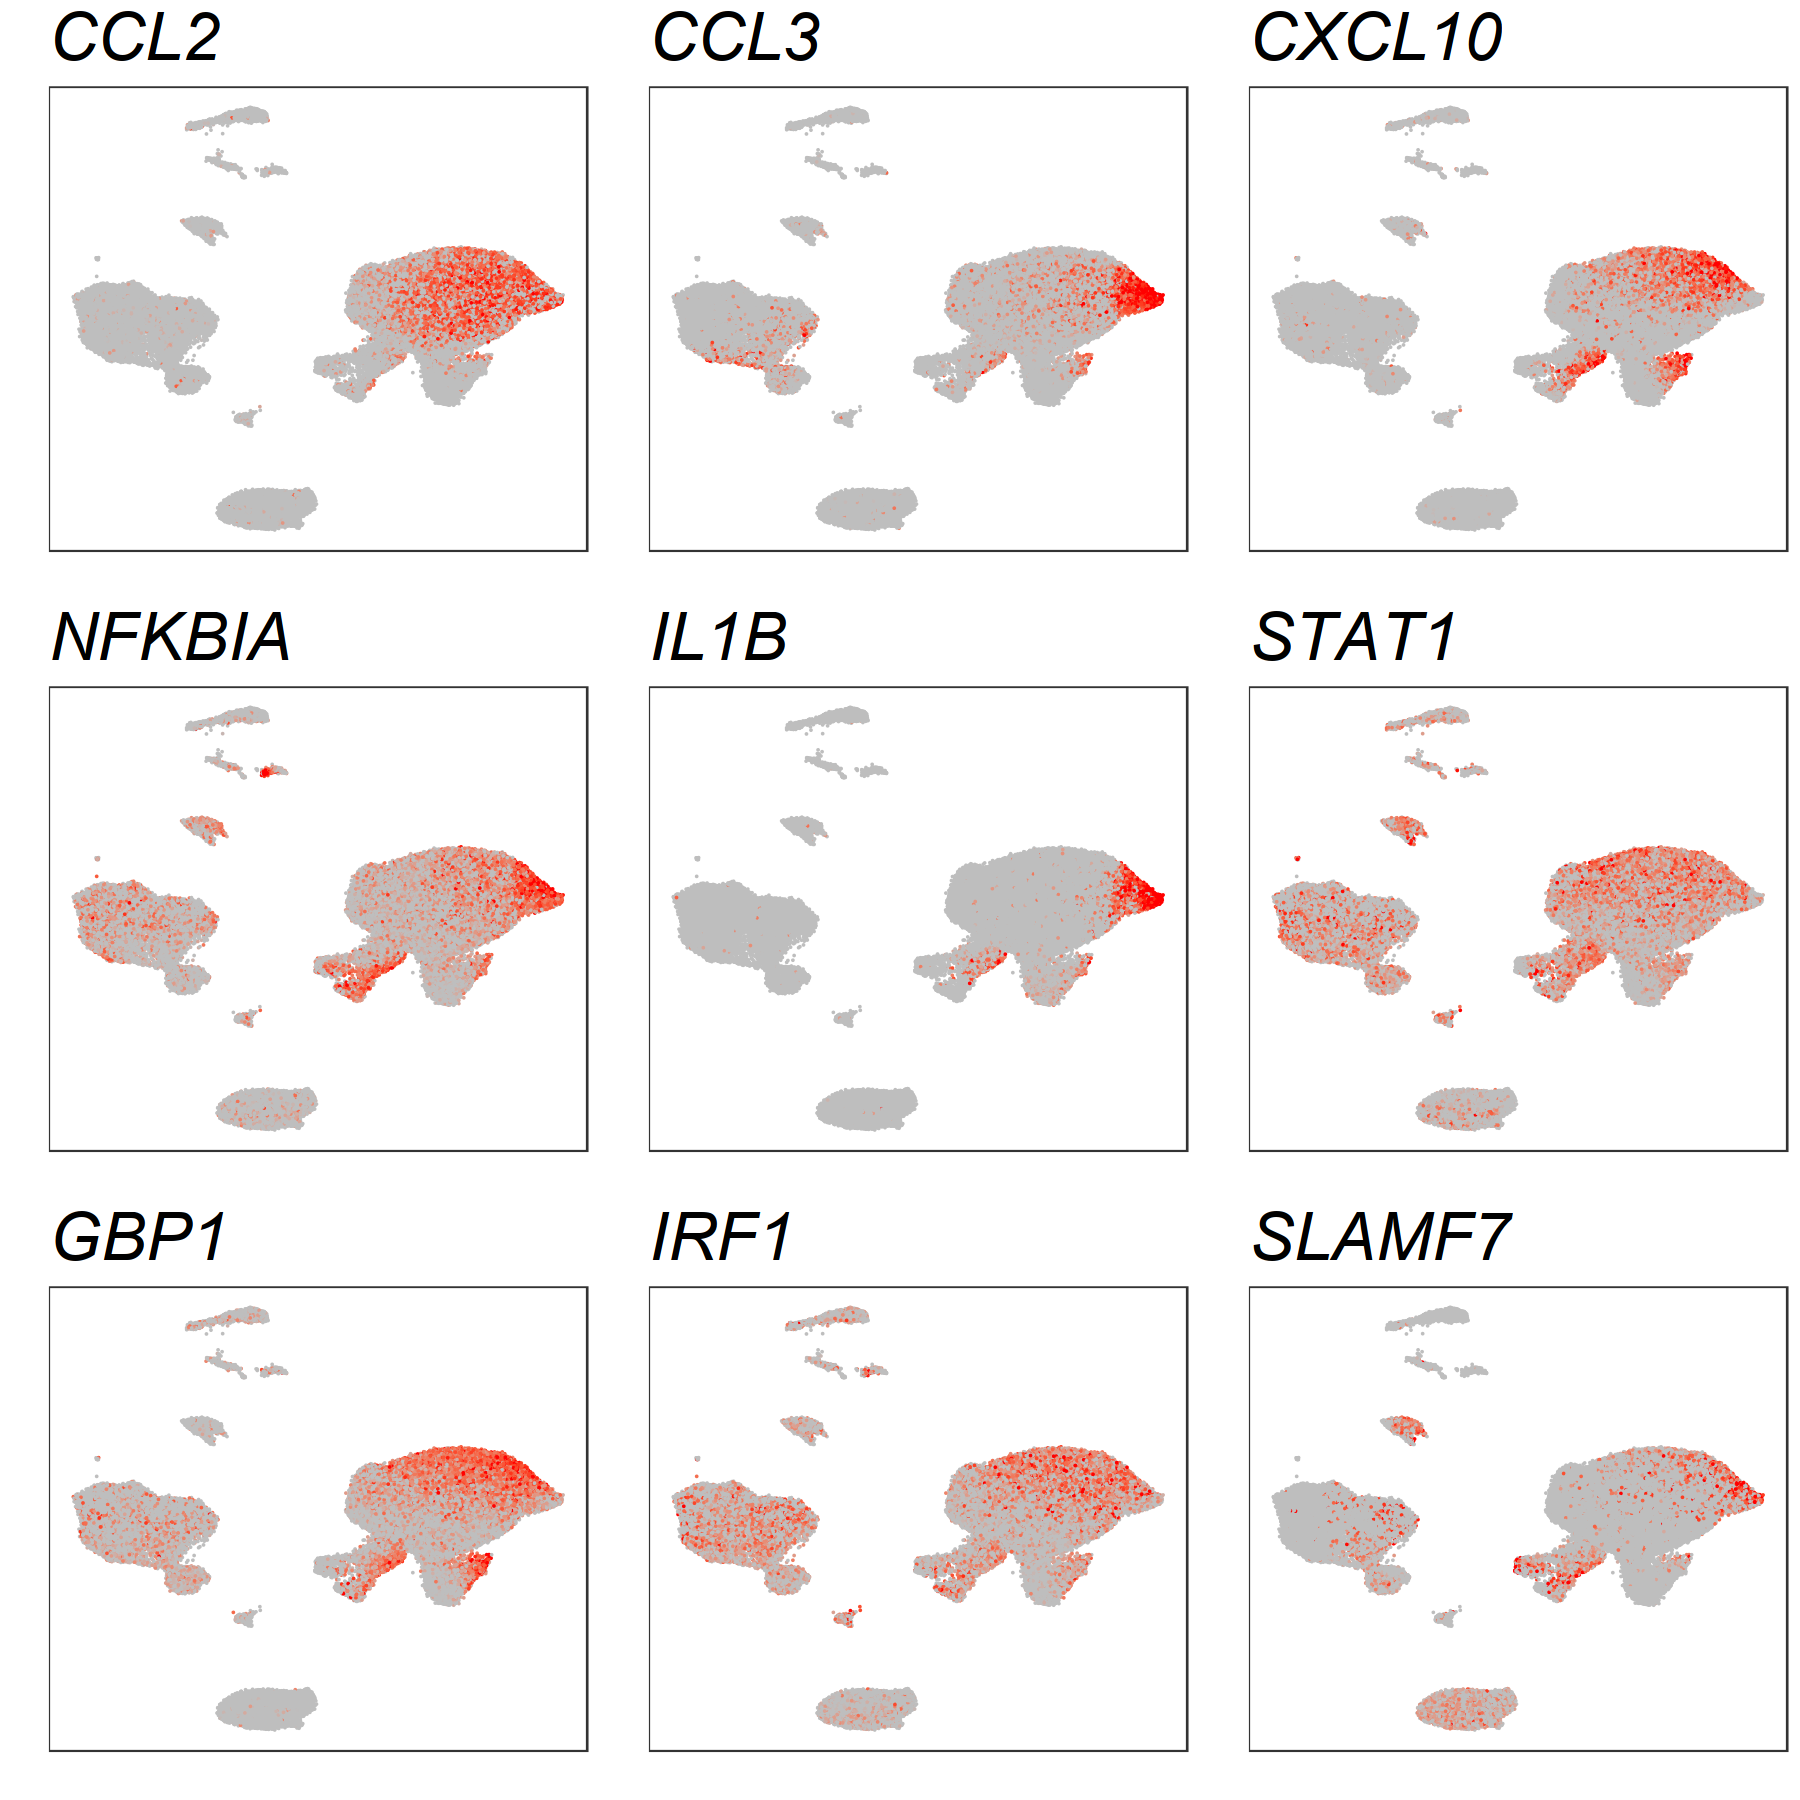

In [146]:
fan_gene <- c("CCL2", "CCL3", "CXCL10", "NFKBIA", "IL1B", "STAT1", "GBP1", "IRF1", "SLAMF7") 

myplots <- list()
  for (i in 1:length(fan_gene)) {
  gene <- fan_gene[i]
    
    max.cutoff = quantile(grant_exp[gene,], .99)
    min.cutoff = quantile(grant_exp[gene,], .01)

    tmp <- sapply(X = grant_exp[gene,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
  
    grant_meta$gene <- as.numeric(tmp)
    

    
   ind <- paste("p", i, sep = "")
   ind <- ggplot(
                 data = grant_meta[sample(nrow(grant_meta)),],
                 aes(x = X_umap1, y = X_umap2)) + 
      geom_point(mapping = aes(color = gene), size = 0.0001) + 
#       scale_color_viridis(option = "plasma", end = .9) +
         scale_color_gradient2(low = "grey", mid = "grey",
                            high = "red" ) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=40, face="italic"),
        legend.position = "none") +
      labs(title = gene)
   myplots[[i]] <- ind
    
    
}

options(repr.plot.height = 15, repr.plot.width = 15)
p <- do.call("grid.arrange", c(myplots, ncol = 3))
ggsave(file = paste("grant_fangene", ".png", sep = ""), p, width = 15, height = 15, dpi = 300)
dev.off()

null device 
          1

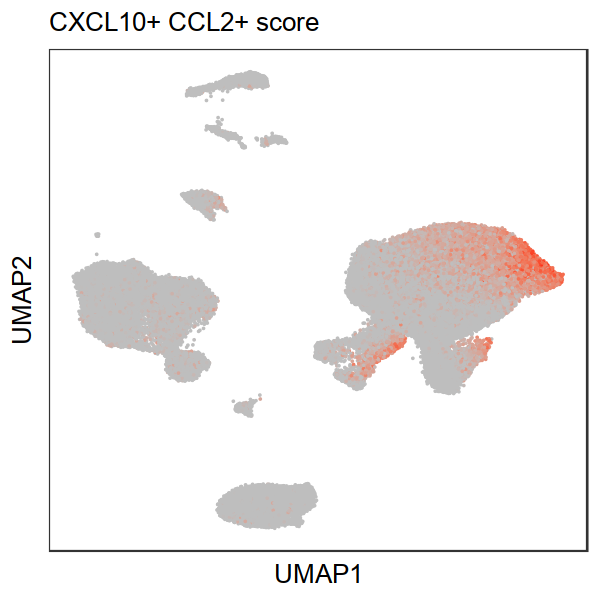

In [162]:
# Create a CXCL10+ CCL2+ score
# Explore using more genes and less genes give similar results
fan_score <- as.matrix(grant_exp[which(rownames(grant_exp) %in% fan_gene),])
fan_score <- colSums2(fan_score) 
# fan_score <- apply(fan_score, 2, function(c) sum(c!=0)/length(c) )
grant_meta$fan_score <- fan_score
                   
options(repr.plot.height = 5, repr.plot.width = 5)
ggplot(
        data = grant_meta[sample(nrow(grant_meta)),],
        aes(x = X_umap1, y = X_umap2)) + 
        geom_point(mapping = aes(color = fan_score), size = 0.001) + 
        scale_color_gradient2(low = "grey", mid = "grey",
                            high = "red" ) +
       labs(x="UMAP1", y="UMAP2", title = "CXCL10+ CCL2+ score")+
       theme_bw(base_size = 15)+
       theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=15),
        legend.position = "none"
      ) 
ggsave(file = paste("grant_gene_score", ".png", sep = ""), width = 5.5, height = 5, dpi = 300)
dev.off()